# Navigation

---

## 1. Prepare dependencies and environment

Take a look at README.md before executing this notebook and make sure that the kernel is set to **p1_navigation**. The environment for this project is [Banana](https://github.com/kotogasy/unity-ml-banana) from Unity, and it's provided in the `setup` folder.

In [1]:
!pip -q install ./setup

import sys

import numpy as np
from numpy_ringbuffer import RingBuffer
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

from setup import unityagents
from unityagents import UnityEnvironment

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Unity environments contain **brains**, our interfaces for controlling agents. We'll be conrtolling the first (default) brain in the environment. It's also useful to keep information such as `state_size` and `action_size`.

In [2]:
env = UnityEnvironment(file_name="setup/Banana.app")

# use the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2. Replay buffer

We'll use the **uniform** variation of the replay buffer here, meaning that all stored tuples have the same chance of being selected for replay. Nonetheless, we can provide some additional methods and data, such as `max_priority()` and `update_priority()`, that will help us write a more abstract agent, in case we want to try the prioritized variant.

Every tuple is stored as `(s, a, r, ns, d, p)` where:

- `s` is the state at the beginning of the timestep
- `a` is the action that was taken
- `r` is the reward obtained in the next timestep
- `ns` is the state at the next timestep (we'll refer to this as $s'$ as well)
- `d` is a boolean value that determines if the episode ended
- `p` is the **priority** of the tuple, ignored in this case and kept here because it will make the transition to the prioritized version easier. At the moment, however, every tuple will be considered with `p = max_priority() = 0` (not stored), _regardless of p_.

When sampling a batch of `n` tuples, we'll obtain a single tuple `([s], [a], [r], [ns], [d], [w])` where:
- `[s]`, `[a]`, `[r]`, `[ns]`, `[d]` are **torch tensors** with `n` rows. Keep in mind that `[s]` and `[ns]` can have more than one column, depending on the `state_size`.
- `[w]` is the `n`-rows tensor of **importance sampling weights**. Since this is the uniform case, every tuple has the weight `1/n`. Again, this is done because it will make the transition to the prioritized version easier.

# todo capacity

In [3]:
class UniformReplayBuffer():

    def __init__(self, capacity):
        self.capacity = capacity
        self.reset()
    
    def reset(self):
        self.buff = RingBuffer(capacity=self.capacity, dtype=object)
    
    def sample(self, n, replace=True):
        samples = np.random.choice(np.array(self.buff), n, replace)
        
        s = torch.FloatTensor([sample[0] for sample in samples])
        a = torch.LongTensor([sample[1] for sample in samples])
        r = torch.FloatTensor([sample[2] for sample in samples])
        ns = torch.FloatTensor([sample[3] for sample in samples])
        d = torch.FloatTensor([sample[4] for sample in samples])
        w = torch.ones(d.size()) / n
        
        return s, a, r, ns, d, w
    
    def add(self, observation):
        s, a, r, ns, d, _ = observation
        self.buff.append((s, a, r, ns, d))
    
    def size(self):
        return len(self.buff)
    
    def max_priority(self):
        return 0
    
    def update_priority(self, observations):
        pass

## 3. Q Network

We have two choices for this network's architecture:

- `DQN`, the original Deep Q-Network
- `DuelingDQN`, the Dueling Deep Q-Network

Both models receive the current state $s$ as input and provide a vector for all estimated $Q(s, a)$ values at once.

### 3.1 DQN

The `DQN` class is straightforward and uses less parameters, since it only uses one stream of fully connected layers:

- `state_size` $\to 64$ followed by `relu` activations
- $64 \to 128$ and `relu`
- $128 \to 64$ and `relu`
- $64 \to Q(s, a)$, that is $64 \to$ `action_size` and no activation

In [69]:
class DQN(nn.Module):
    
    def __init__(self, state_size, action_size, hidden_layers=[256, 256, 64, 32]):
        super(DQN, self).__init__()
        
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        A = hidden_layers[:-1]  # -> [64, 128] (using the predefined values)
        B = hidden_layers[1:]   # -> [128, 64]
        in_out = zip(A, B)      # -> [(64, 128), (128, 64)]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in in_out])
        
        self.output_layer = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, state):
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.relu(state)
        state = self.output_layer(state)
        return state

### 3.2 DuelingDQN

On the other hand, `DuelingDQN` has two streams of independent layers: the **value** of a state $V(s)$ (scalar) and the **advantage** of taking an action $A(s, a)$ (same shape as the output), related by $A(s, a) = Q(s, a) - V(s)$. The idea is that, in many scenarios, the value of a state won't depend that much on the action the agent takes, so decoupling these values can help make better estimates.

So, the class `DuelingDQN` uses two identical streams of independent fully connected layers:

- `state_size` $\to 64$ and `relu`
- $64 \to 128$ and `relu`
- $128 \to 64$ and `relu`

The streams end in:

- $64 \to A(s, a)$, that is $64 \to$ `action_size` and no activation
- $64 \to V(s)$, that is $64 \to 1$ and no activation

To merge them, however, we can't simply add $V$ and $A$ as $Q(s, a) = V(s) + A(s, a)$, because $A$ and $V$ **won't be identifiable**. We can, instead, write

$$Q(s, a) = V(s) + A(s, a) - \max_{a'} A(S, a')$$

so that when the best action $a^*$ is selected, we get that $Q(s, a^*) = V(s)$, something that is not guaranteed otherwise. To further improve this, we can substitute the $\max$ operator for a mean of the available actions. This is the final equation used in the `DuelingDQN` class, where $|\mathbb{A}(s)| =$ `action_size`.

$$Q(s, a) = V(s) + A(s, a) - \frac{1}{|\mathbb{A}(s)|} \sum_{a' \in \mathbb{A}(s)} A(s, a')$$

In [66]:
class DuelingDQN(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers=[256, 256, 64, 32]):
        super(DuelingDQN, self).__init__()
        
        self.value_hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        self.advantage_hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        A = hidden_layers[:-1]  # -> [32, 128] (using the predefined values)
        B = hidden_layers[1:]   # -> [128, 32]
        # zip(A, B)             # -> [(32, 128), (128, 32)]
        self.value_hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])
        self.advantage_hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])
        
        self.value_output_layer = nn.Linear(hidden_layers[-1], 1)
        self.advantage_output_layer = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, x):
        V = x
        A = x.clone()
        for value_layer, advantage_layer in zip(self.value_hidden_layers, self.advantage_hidden_layers):
            V, A = value_layer(V), advantage_layer(A)
            V, A = F.relu(V), F.relu(A)
        V, A = self.value_output_layer(V), self.advantage_output_layer(A)
        return V + A - torch.mean(A, dim=1).unsqueeze(1)

## 4. Temporal-Difference error estimation

Since this is a bootstrapping method, when we're calculating the **temporal-difference** error $\delta_t$ we'll have to rely on an estimate of future returns. Two proposed variants for this are fixed Q-targets and Double DQN.

The functions `dt_dqn`, `dt_double_dqn` implement these two variants. Both take an extra boolean parameter `d` that signals when the episode is over, since in that case, there is no future return and the TD error is simply $\delta_t = r - Q(s, a)$.

Note that these functions expect `s`, `a`, `r`, `ns` and `d` as **torch tensors**, where the number of rows indicates the batch size. The return value is also a vector with the same number of rows, one for each tuple.

#### 4.1 Fixed Q-targets

The original paper proposed the method of fixed Q-targets, essentially **duplicating the network**, creating $Q_{local}$ and $Q_{target}$, where the former is used to determine the policy and the latter is updated less frequently and only used to estimate future returns. In particular, the equation for $\delta_t$ is

$$\delta_t(s, a, r, s') = r + \gamma \max_{a'} Q_{target}(s', a') - Q_{local}(s, a)$$

In [6]:
def dt_dqn(s, a, r, ns, d, q_local, q_target, gamma):
    with torch.no_grad():   # no need for gradients when we're evaluating the TD target
        QT = q_target(ns)   # evaluate the next state using the target network (out: [n * action_size])
        QT = QT.max(1)      # take the max along the column (actions) (out: two tensors [n])
        QT = QT[0]          # - [0] has the max values for each element in the batch, 
                            # - [1] has the indexes of the max values

    a = a.unsqueeze(1)      # reshape [n] -> [n * 1]
    QL = q_local(s)         # evaluate the current state using the local network (out: [n * action_size])
    QL = QL.gather(1, a)    # for each row, take the column in QL indicated by a (out: [n * 1])
    QL = QL.squeeze(1)      # reshape [n * 1] -> [n]

    return r + gamma * QT * (1 - torch.FloatTensor(d)) - QL

### 4.2 Double DQN

This is largely based on fixed Q-targets, since it also uses $Q_{local}$ and $Q_{target}$. We can rewrite $\max Q$ using $\arg \max$ to break down the task of **choosing** and **evaluating** an action in two different steps.

$$\max_{a'} Q_{target}(s', a') = Q_{target}(s', \arg \max_{a'} Q_{target}(s', a'))$$

This can lead to the **overestimation** of targets. Simply put, when taking the $\max$ among noisy numbers (which is especially true in the beginning) we're likely to pick the action where the approximator adds more positive noise. Separating the task of picking and evaluating the action to two different approximators may decrease this issue, since both networks now have to "agree" on the outcome of an action.

The original estimate can be improved using the one provided in the Double DQN paper. The proposed solution is to use $Q_{local}$ for the choice and $Q_{target}$ for the evaluation as follows

$$
Q_{target}(s', \arg \max_{a'} Q_{local}(s', a'))\\
\implies \delta_t(s, a, r, s') = r + \gamma Q_{target}(s', \arg \max_{a'} Q_{local}(s', a')) - Q_{local}(s, a)
$$

In [5]:
def dt_double_dqn(s, a, r, ns, d, q_local, q_target, gamma):
    with torch.no_grad():         # no need for gradients when we're evaluating the TD target
        QLns = q_local(ns)        # evaluate the next state using the local network (out: [n * action_size])
        QLns = QLns.max(1)        # take the max along the column (actions) (out: two tensors [n])
        QLns = QLns[1]            # [1] has the indexes of the max values
        QLns = QLns.unsqueeze(1)  # reshape [n] -> [n * 1]

        QT = q_target(ns)         # evaluate the next state using the target network (out: [n * action_size])
        QT = QT.gather(1, QLns)   # for each row, take the value estimated by the target network for
                                  # the best action estimated by the local network (out: [n * 1])
        QT = QT.squeeze(1)        # reshape [n * 1] -> [n]

    a = a.unsqueeze(1)            # reshape [n] -> [n * 1]
    QL = q_local(s)               # evaluate the current state using the local network (out: [n * action_size])
    QL = QL.gather(1, a)          # for each row, take the column in QL indicated by a (out: [n * 1])
    QL = QL.squeeze(1)            # reshape [n * 1] -> [n]

    return r + gamma * QT * (1 - torch.FloatTensor(d)) - QL

## 5. Agent

Let's put the pieces together. During initialization, we can configure the agent's:

- `QNetwork`, which is either the class `DQN` or `DuelingDQN` (_not an instance_)
- `replay_buffer`, which is an instance of `UniformReplayBuffer` (could be replaced with a `PrioritizedReplayBuffer`)
- `Delta, which` is either the function `dt_dqn` or `dt_double_dqn`

Other parameters are obviously `state_size` and `action_size` as well as some hyperparameters:

- `alpha` $\in [0, 1]$, the learning rate to apply to gradient steps to `q_local`
- `eps`, `eps_decay` and `min_eps` $\in [0, 1]$, for the $\epsilon$-greedy policy, if `learning = False` only the greedy policy will be used
- `gamma` $\in [0, 1]$, the weight of the estimates for future returns calculated by `q_target` in the function `Delta`
- `tau` $\in [0, 1]$, to perform soft updates of `q_target`, if set to $1$ directly copies `q_local` into `q_target`
- `update_every` the number of steps to wait before updating `q_local` and `q_target`
- `batch_size` the number of samples from the `replay_buffer` used to perform one update of `q_local`

The agent has three functions, but only the first two should be called from the outside: 
- `act`, based on a state tensor `s` and on `eps`, choose an action. If the agent has `learning = False` the choice will be greedy.
- `store`, receive a tuple to put in the `replay_buffer`. This counts as a step towards the updates of `q_local` and `q_target`, and in fact calls `learn()` automatically when needed.
- `learn`, samples a batch of tuples from the `replay_buffer`, calculates their $\delta_t$ and finally performs gradient descent on `q_local` and a soft update of `q_target` towards `q_local`. Note that it can already perform actions related to a tuple's priority and importance sampling weight.

Additionally, an agent can be `reset()`.

In [52]:
class QNetworkAgent():
    
    def __init__(self, QNetwork, state_size, action_size, 
                 replay_buffer, Delta, 
                 eps=1, eps_decay=0.9995, min_eps=0.0001, gamma=0.99, 
                 alpha=0.001, tau=0.01,
                 update_every=15, batch_size=64, learning=True):
        self.state_size, self.action_size = state_size, action_size
        self.original_eps = eps
        self.QNetwork = QNetwork
        self.replay_buffer = replay_buffer
        self.Delta = Delta
        self.learning = learning
        self.eps, self.eps_decay, self.min_eps = eps, eps_decay, min_eps
        self.gamma, self.alpha, self.tau = gamma, alpha, tau
        self.update_every, self.batch_size = update_every, batch_size
        self.reset()
    
    def reset(self):
        self.replay_buffer.reset()
        self.eps = self.original_eps
        self.q_local, self.q_target = self.QNetwork(self.state_size, self.action_size), self.QNetwork(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.q_local.parameters(), lr=self.alpha)
        self.update_i = 0

    def act(self, s):
        if not self.learning or np.random.uniform() > self.eps:
            with torch.no_grad():
                s = torch.FloatTensor(s).unsqueeze(0)  # out: [1 * action_size]
                return int(self.q_local(s).max(1)[1])
        else:
            return np.random.randint(self.action_size)
    
    def store(self, s, a, r, ns, d):
        p = self.replay_buffer.max_priority()
        self.replay_buffer.add((s, a, r, ns, d, p))
        if self.update_i == 0 and self.replay_buffer.size() >= self.batch_size:
            self.learn()
            self.eps = max(self.eps * self.eps_decay, self.min_eps)
        self.update_i = (self.update_i + 1) % self.update_every
    
    def learn(self):
        s, a, r, ns, d, w = self.replay_buffer.sample(self.batch_size)
        td_delta = self.Delta(s, a, r, ns, d, self.q_local, self.q_target, self.gamma)
        self.replay_buffer.update_priority(zip(s, a, r, ns, d, torch.abs(td_delta)))
                
        self.optimizer.zero_grad()
        loss = torch.sum(w * (td_delta ** 2))  # weighted mse
        loss.backward()
        self.optimizer.step()
        
        with torch.no_grad():  # soft updates of q_target don't need autograd, since they're copied (or interpolated) from q_local
            for local, target in zip(self.q_local.parameters(), self.q_target.parameters()):
                target.copy_(target + self.tau * (local - target))

To create an agent, we really just need a few lines now.

In [11]:
agent = QNetworkAgent(
    DuelingDQN,
    state_size, action_size,
    UniformReplayBuffer(100_000),
    dt_double_dqn
)

## 6. Training an agent

What we need now is a function that connects our `agent` and `env`. Recall that we'll be using the default `brain_name` to interact with this environment.

Also, we should **monitor** what happens so that we'll be able to compare different approaches. Our most important indicator is going to be the average score over 100 consecutive episodes: the environment is considered **solved when the agent scores +13 or more** under this metric. To reduce noise in the output, we'll be training the agent 10 times from scratch, for 1000 episodes, and we'll average these results.

After we compare the results and find out which strategy performs best, we can train an agent of that type with `repeat=1` for reasonable number of episodes, and we're done.

In [63]:
def execute_episode(agent, env):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    done = False
    while not done:
        action = agent.act(state)

        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]

        agent.store(state, action, reward, next_state, done)
        score += reward
        state = next_state
    return score

def train(agent, env, episode_function, episodes=1000, repeat=10, consecutive_episodes=100, show_output=True):

    results = [None] * repeat
    for r in range(repeat):
        
        agent.reset()
        partial_results = [None] * episodes
        for i in range(episodes):
            score = episode_function(agent, env)
            partial_results[i] = score
            
            if show_output:
                print("\r[{}] Episode: {}, Score: {}".format(r+1, i+1, score), end="")
                sys.stdout.flush()
        
        if show_output:
            print()

        results[r] = partial_results
    
    # use convolutions to calculate the mean and standard deviation summarizing the training step
    results = np.array(results)
    mean = signal.convolve2d(results, np.ones([repeat, consecutive_episodes]) / (repeat * consecutive_episodes), mode='valid')    
    v = signal.convolve2d(results, np.ones([1, consecutive_episodes]) / consecutive_episodes, mode='valid')
    std_dev = signal.convolve2d(v ** 2 - mean ** 2, np.ones([repeat, 1]) / repeat, mode='valid') ** (1/2)
    return mean.flatten(), std_dev.flatten(), results

In [19]:
agents = [('DQN', QNetworkAgent(DQN, state_size, action_size, UniformReplayBuffer(100_000), dt_dqn)),
          ('Double DQN', QNetworkAgent(DQN, state_size, action_size, UniformReplayBuffer(100_000), dt_double_dqn)),
          ('Dueling DQN', QNetworkAgent(DuelingDQN, state_size, action_size, UniformReplayBuffer(100_000), dt_dqn)),
          ('Dueling Double DQN', QNetworkAgent(DuelingDQN, state_size, action_size, UniformReplayBuffer(100_000), dt_double_dqn))]

training_results = []
for ag in [agents[-1]]:
    name, agent = ag
    print('Agent: {}'.format(name))
    mean, std_dev, full_report = train(agent, env, episode_function=execute_episode, repeat=1, episodes=1000)
    training_results.append((mean, std_dev, full_report))

Agent: Dueling Double DQN
[1] Episode: 1000, Score: 3.0


In [60]:
# torch.save(agents[-1][1].q_local.state_dict(), 'checkpoint3.pth')
# torch.save(agents.q_local.state_dict(), 'checkpoint.pth')
# agent.q_local.load_state_dict(torch.load('checkpoint.pth', map_location='cpu'))

## 7. Comparison of the results and issues

We can use `matplotlib` to plot the mean of the score and the standard deviation. Clearly all algorithms proposed manage to score an average of 13 points or more on 100 consecutive runs, thus solving the environment, and they do so in less than 500 episodes. Nonetheless, `Double DQN` and `Dueling DQN` allow the agent to perform even better and to solve the environment even earlier. In particular, `dt_double_dqn` seems to make learning **more stable** while `DuelingDQN` seems to approximate **more optimal** policies.

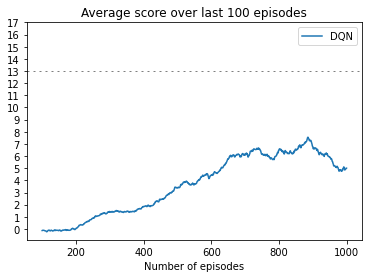

In [22]:
def plot_mean_std_dev(agents, training_results):
    for agent, ts in zip(agents, training_results):
        mean, std_dev, _ = ts
        x = np.arange(100, 100 + mean.size)
        plt.plot(x, mean, label = agent[0])
        plt.fill_between(x, mean + std_dev, mean - std_dev, alpha=0.1)

    plt.axhline(13, dashes=(4, 8), lw=0.5, color='black')
    plt.yticks(np.arange(0, 18))
    plt.xlabel('Number of episodes')
    plt.title('Average score over last 100 episodes')
    plt.legend()
    plt.show()

plot_mean_std_dev(agents[:2], training_results[:2])
# plot_results(agents[2:], training_results[2:])

However, if we take a closer look at the data, we can see that even our best agents are not very stable, even after hundreds of episodes. If we consider the t-th episode of each of the 10 training sessions, we can see that the minimum between them stays consistently low. This shouldn't be an issue in this environment, considering its deterministic nature.

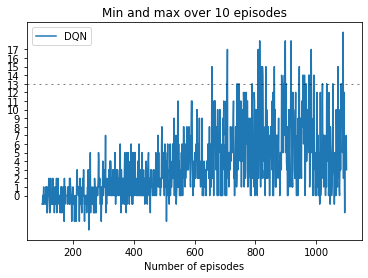

In [23]:
def plot_min(agents, training_results):
    for agent, ts in zip(agents, training_results):
        _, _, full_report = ts

        m = np.min(full_report, axis=0)
        M = np.max(full_report, axis=0)
        x = np.arange(100, 100 + m.size)
        plt.plot(x, m, label = agent[0])
        plt.fill_between(x, M, m, alpha=0.1)

    plt.axhline(13, dashes=(4, 8), lw=0.5, color='black')
    plt.yticks(np.arange(0, 18))
    plt.xlabel('Number of episodes')
    plt.title('Min and max over 10 episodes')
    plt.legend()
    plt.show()

plot_min(agents[:2], training_results[:2])
# plot_results(agents[2:], training_results[2:])

Most episodes are played just fine, but if you watch an agent play, eventually you'll see an episode like this.

![SegmentLocal](imgs/gif_1.gif "segment")

## 8. Short term memory

This issue probably arises because the state does not contain information about how the agent acted in the last few steps. Although the original DQN paper worked directly on pixels, to overcome this issue they provided four consecutive frames to the agent, instead of one. Luckily we can do something similar in our environment.

We can start by creating our agents with an input that is `3 * state_size`.

In [72]:
agents = [('DQN', QNetworkAgent(DQN, 6 * state_size, action_size, UniformReplayBuffer(100_000), dt_dqn)),
          ('Double DQN', QNetworkAgent(DQN, 6 * state_size, action_size, UniformReplayBuffer(100_000), dt_double_dqn)),
          ('Dueling DQN', QNetworkAgent(DuelingDQN, 6 * state_size, action_size, UniformReplayBuffer(100_000), dt_dqn)),
          ('Dueling Double DQN', QNetworkAgent(DuelingDQN, 6 * state_size, action_size, UniformReplayBuffer(100_000), dt_double_dqn))]

Then, during training, we can concatenate three consecutive states in a single vector, and provide the result to the agent.

In [62]:
def execute_episode_v2(agent, env):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    done = False

    # replicate the first state three times
    consecutive_states = [state] * 6
    # merge three states into one
    edited_state = np.array(consecutive_states).flatten()

    while not done:
        action = agent.act(edited_state)

        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]

        consecutive_states.pop(0)
        consecutive_states.append(next_state)
        edited_next_state = np.array(consecutive_states).flatten()

        agent.store(edited_state, action, reward, edited_next_state, done)
        score += reward
        edited_state = edited_next_state
    return score

In [73]:
training_results = []
for ag in [agents[0]]:
    name, agent = ag
    print('Agent: {}'.format(name))
    mean, std_dev, full_report = train(agent, env, episode_function=execute_episode_v2, repeat=1, episodes=1000)
    training_results.append((mean, std_dev, full_report))

Agent: DQN
[1] Episode: 1000, Score: 17.0


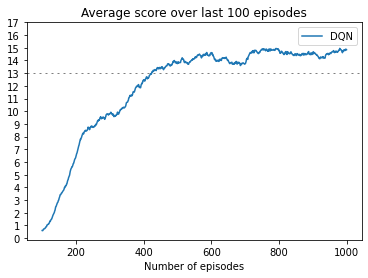

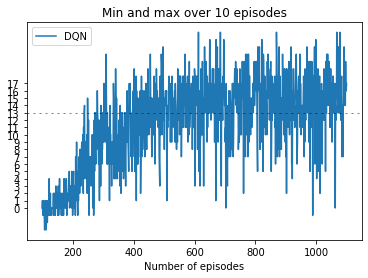

In [74]:
plot_mean_std_dev(agents[:2], training_results[:2])
# plot_results(agents[2:], training_results[2:])
plot_min(agents[:2], training_results[:2])
# plot_min(agents[2:], training_results[2:])

In [44]:
agent = QNetworkAgent(DQN, state_size, action_size, UniformReplayBuffer(100_000), dt_dqn)
agent.q_local.load_state_dict(torch.load('checkpoint.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]
agent.learning = False
state = env_info.vector_observations[0]
score = 0
done = False
while not done:
    action = agent.act(state)

    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]

    agent.store(state, action, reward, next_state, done)
    score += reward
    state = next_state
print(score)

2.0


In [10]:
env.close()